# SYSID - Atividade 08

Aluno: Pedro Henrique Cardoso Paulo<br>

Professor: Helon

## Objetivo

TBD

## Passo 0 - Importando bibliotecas

In [31]:
# Pacotes padrao
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import datetime

#sysidentpy
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.general_estimators.narx import NARX
from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation

#Pipeline
from sklearn.pipeline import Pipeline

#Tratamento
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Modelos
from sklearn.model_selection import RandomizedSearchCV

# Scores
from sklearn.metrics import r2_score

#Definindo random_state
rs = 85

## Passo 0 - Importando os dados

### 0.1 - Lendo dados

In [32]:
binary = os.path.join(os.getcwd(), 'data', 'volve_compiled.pkl')
print(binary)

with open(binary, 'rb') as bin_file:
    data = pickle.load(bin_file)

/mnt/d/OneDrive/Mestrado/Semestre 02/SYSID/SYSID_Trabalho/Volve-Dataset/data/volve_compiled.pkl


### 0.2 - Visualizando dados

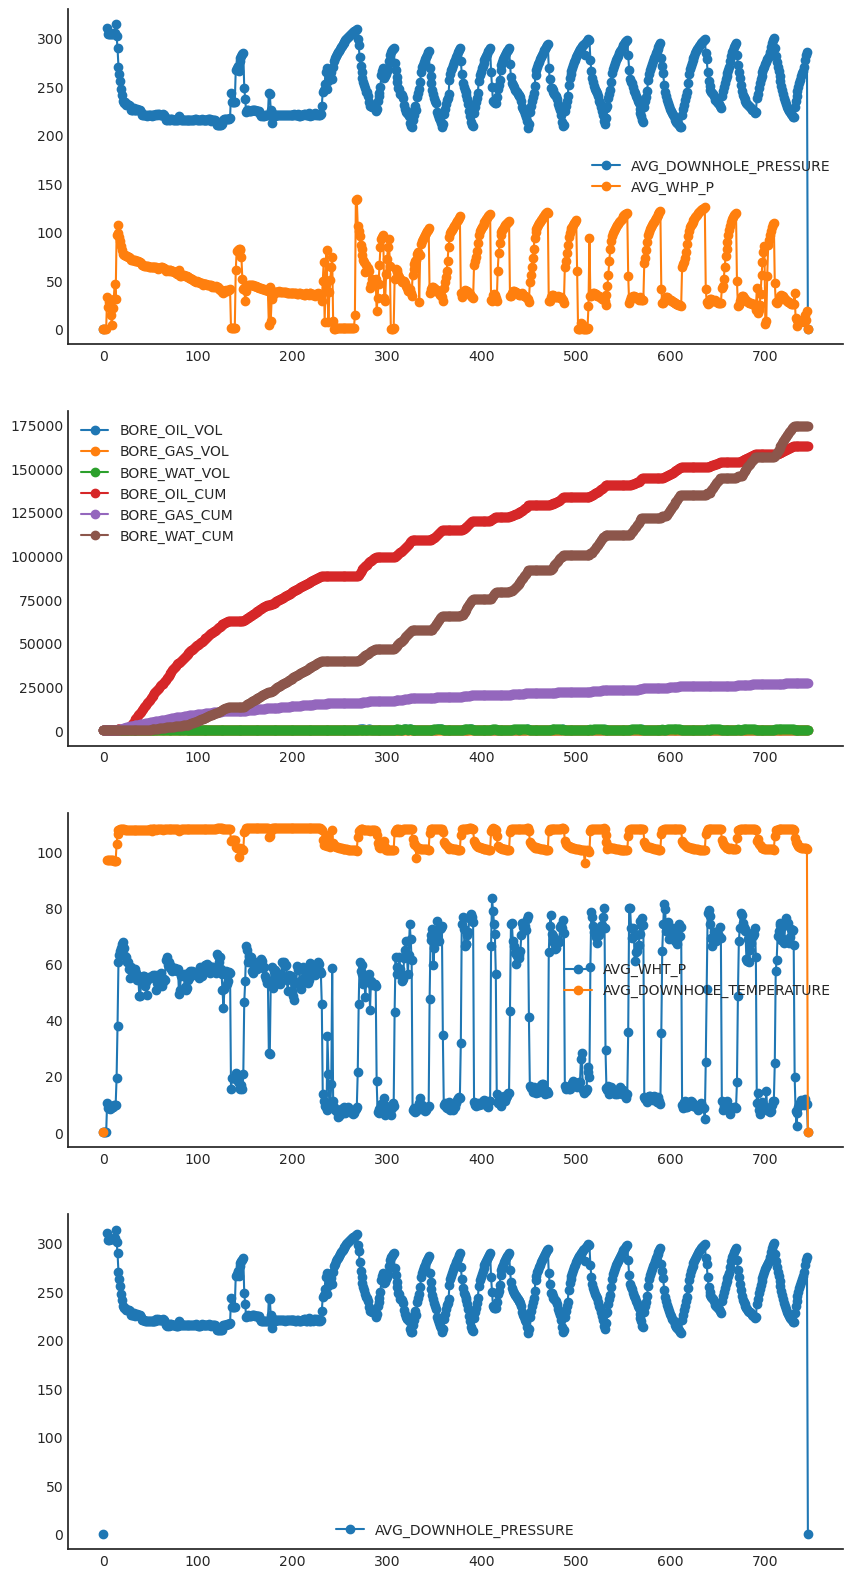

In [33]:
case = "15/9-F-1 C"

data_case = data['OP'][case]

filt_vars_IN_Q =  [
        'BORE_OIL_VOL',
        'BORE_GAS_VOL',
        'BORE_WAT_VOL',
        'BORE_OIL_CUM',
        'BORE_GAS_CUM',
        'BORE_WAT_CUM',
]

filt_vars_IN_QINJ = [
        'BORE_WI_VOL',
        'BORE_WI_CUM',
]

filt_vars_IN_P = [
        'AVG_DOWNHOLE_PRESSURE',
        'AVG_WHP_P',
        #'AVG_DP_TUBING',
        # 'AVG_ANNULUS_PRESS',
        # 'AVG_CHOKE_SIZE_P',
        # 'AVG_CHOKE_UOM',
        # 'DP_CHOKE_SIZE',
]

filt_vars_IN_T = [
        'AVG_WHT_P',
        'AVG_DOWNHOLE_TEMPERATURE',
]

filt_vars_OUT = [
        #'BORE_OIL_VOL',
        'AVG_DOWNHOLE_PRESSURE',
]

time = data_case['N']
fig, ax = plt.subplots(4,1, figsize=(10, 20))
for var in filt_vars_IN_P:
    ax[0].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_IN_Q:
    ax[1].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_IN_T:
    ax[2].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_OUT:
    ax[3].plot(time, data_case[var], '-o', label=var)
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

In [34]:
data_case = data_case.set_index('DATEPRD')
data_case = data_case[filt_vars_IN_Q + filt_vars_IN_P + filt_vars_IN_T]
y =  data_case[filt_vars_OUT].values
for well in data['OP'].keys():
    if well == case: continue
    data_case = data_case.join(data['OP'][well][['DATEPRD'] + filt_vars_IN_Q + filt_vars_IN_P + filt_vars_IN_T+filt_vars_OUT].set_index('DATEPRD'), lsuffix=case, rsuffix=well)
for well in data['WI'].keys():
    if well == case: continue
    data_case = data_case.join(data['WI'][well][['DATEPRD'] + filt_vars_IN_QINJ + filt_vars_IN_P].set_index('DATEPRD'), lsuffix=case, rsuffix=well)


/tmp/ipykernel_29530/3487109583.py:6: FutureWarning: Passing 'suffixes' which cause duplicate columns {'BORE_OIL_VOL15/9-F-1 C', 'BORE_WAT_CUM15/9-F-1 C', 'AVG_DOWNHOLE_TEMPERATURE15/9-F-1 C', 'AVG_WHT_P15/9-F-1 C', 'AVG_WHP_P15/9-F-1 C', 'BORE_GAS_VOL15/9-F-1 C', 'BORE_WAT_VOL15/9-F-1 C', 'AVG_DOWNHOLE_PRESSURE15/9-F-1 C', 'BORE_GAS_CUM15/9-F-1 C', 'BORE_OIL_CUM15/9-F-1 C'} in the result is deprecated and will raise a MergeError in a future version.
  data_case = data_case.join(data['OP'][well][['DATEPRD'] + filt_vars_IN_Q + filt_vars_IN_P + filt_vars_IN_T+filt_vars_OUT].set_index('DATEPRD'), lsuffix=case, rsuffix=well)
/tmp/ipykernel_29530/3487109583.py:6: FutureWarning: Passing 'suffixes' which cause duplicate columns {'BORE_OIL_VOL15/9-F-1 C', 'BORE_WAT_CUM15/9-F-1 C', 'AVG_DOWNHOLE_TEMPERATURE15/9-F-1 C', 'AVG_WHT_P15/9-F-1 C', 'AVG_WHP_P15/9-F-1 C', 'BORE_GAS_VOL15/9-F-1 C', 'BORE_WAT_VOL15/9-F-1 C', 'AVG_DOWNHOLE_PRESSURE15/9-F-1 C', 'BORE_GAS_CUM15/9-F-1 C', 'BORE_OIL_CUM15/9-F

In [35]:
data_case = data_case.dropna(axis=1)
data_case = data_case.dropna().iloc[240:,:]
y = y[240:,:]
#data_case = data_case[filt_vars_IN_Q + filt_vars_IN_P + filt_vars_IN_T + filt_vars_OUT].dropna()
X1 = data_case.values

## Passo 1 - Separando os dados em treino e teste

### 1.1 - Definindo a parcela de treino e de teste

In [36]:
p_train = 0.5 #50% treino

### 1.2 - Separando os conjuntos

In [37]:
n_train = int(X1.shape[0]*p_train)
X1_tr = X1[:n_train,:]
y_tr = y[:n_train,:]
X1_te = X1[n_train:,:]
y_te = y[n_train:,:]

In [38]:
print(
    X1_tr.shape,
    X1_te.shape,
    y_tr.shape
)

(253, 54) (253, 54) (253, 1)


### 1.3 - Normalizando as variáveis

In [39]:
scaler_X = MinMaxScaler().fit(X1_tr)
scaler_y = MinMaxScaler().fit(y_tr)

X1_tr = scaler_X.transform(X1_tr)
X1_te = scaler_X.transform(X1_te)

y_tr  = scaler_y.transform(y_tr)
y_te  = scaler_y.transform(y_te) 

### 1.4 - Aplicando PCA

In [40]:
pca_X = PCA(0.99).fit(X1_tr)

X1_tr = pca_X.transform(X1_tr)
X1_te = pca_X.transform(X1_te)

print(X1_tr.shape)

(253, 17)


## Passo 2 - Iniciando a construção do modelo ARMAX/NARMAX

Para essa atividade, vamos usar a biblioteca sysidentpy. Essa biblioteca guarda grandes similaridades com bibliotecas da área de machine learning, como `scikit-learn`, `tensorflow` e `pytorch`.
Como na <a href="../Atividade06/Atividade06.ipynb">Atividade 06</a> o modelo que usamos de base mostrou-se divergente para a simulação livre, vamos aqui tentar propor um modelo ligeiramente diferente de base, com `na = nb = 6`. Além disso, vamos adicionar 4 termos não-lineares por padrão nos coeficientes do ajuste por meio do parâmetro n_terms.

### 2.1 - Selecionando a arquitetura (NARMAX)

Para esse caso, como o númeroo de termos tende a crescer muito, vamos deixar o sysidentpy selecionar a ordem de nossos modelos

In [41]:
#basis_function = Polynomial(degree=2)
basis_function = Fourier(degree=2)
n = 6
na = n
nb = [n] * X1.shape[1]
ne = 1
n_terms = 10
model_NARMAX = FROLS(
    order_selection=True,
    ylag=na, xlag=nb,elag=ne,
    basis_function=basis_function,
    n_info_values=100,
    n_terms=n_terms,
    model_type='NARMAX',
    #extended_least_squares=True,
)

### 2.3 - Selecionando arquitetura (ARMAX)

In [42]:
basis_function = Polynomial(degree=1)
n = 6
na = n
nb = [n] * X1.shape[1]
ne = 1
n_terms = 10
model_ARMAX = FROLS(
    order_selection=True,
    ylag=na, xlag=nb,elag=ne,
    basis_function=basis_function,
    n_info_values=100,
    #n_terms=n_terms,
    model_type='NARMAX',
    extended_least_squares=True,
)

## Passo 3 - Realizando ajuste inicial

### 3.1 - Performando o ajuste

In [43]:
model_NARMAX.fit(X=X1_tr, y=y_tr)
model_ARMAX.fit(X=X1_tr, y=y_tr)

/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/sysidentpy/model_structure_selection/forward_regression_orthogonal_least_squares.py:476: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 24 
  self.info_values = self.information_criterion(reg_matrix, y)


### 3.2 - Visualizando os resultados (NARMAX)

In [44]:
r = pd.DataFrame(
    results(
        model_NARMAX.final_model, model_NARMAX.theta, model_NARMAX.err,
        model_NARMAX.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
r

,Regressors,Parameters,ERR
0,y(k-1),1.5106E+00,9.88060408E-01
1,y(k-2),-4.8913E-01,4.61211092E-03
2,x5(k-6)y(k-3),-1.6810E-01,3.81326965E-04
3,x6(k-3)y(k-1),1.0601E-02,3.53333388E-04
4,x12(k-5)y(k-5),-5.7031E-02,1.39946370E-04
5,x9(k-5)x1(k-2),4.8403E-01,9.40442834E-05
6,x10(k-4)y(k-5),1.2955E-02,1.05248523E-04
7,x11(k-6)y(k-2),4.6332E-01,9.76762941E-05
8,y(k-5)y(k-2),-1.6750E-01,9.15181992E-05
9,x4(k-3)x1(k-2),-2.7168E-01,9.26407644E-05


### 3.3 - Visualizando os resultados (ARMAX)

In [45]:
r = pd.DataFrame(
    results(
        model_ARMAX.final_model, model_ARMAX.theta, model_ARMAX.err,
        model_ARMAX.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
r

,Regressors,Parameters,ERR
0,y(k-1),1.4442E+00,9.88060408E-01
1,y(k-2),-4.5658E-01,4.61211092E-03
2,1,1.9793E-02,3.17212788E-04
3,y(k-6),-7.7886E-02,2.58402141E-04


### 3.4 - Comentários

Nota-se ao olharmos os valores do ajuste que os coeficientes lineares ficam sendo os de maior peso em ambos os casos. Além disso, a ordem dos coeficientes lineares em ambos os ajustes é a mesma, de modo que é esperado que os ajustes fiquem bem próximos, com os coeficientes lineares sendo os dominantes e pouco ganho n aplicação do NARMAX.

## Passo 4 - Comparando os resultados

### 4.1 - Calculando predição OSA

In [46]:
y_tr_pr_OSA_NARMAX = model_NARMAX.predict(X=X1_tr, y=y_tr,steps_ahead=1)
y_te_pr_OSA_NARMAX = model_NARMAX.predict(X=X1_te, y=y_te,steps_ahead=1)

y_tr_pr_OSA_ARMAX = model_ARMAX.predict(X=X1_tr, y=y_tr,steps_ahead=1)
y_te_pr_OSA_ARMAX = model_ARMAX.predict(X=X1_te, y=y_te,steps_ahead=1)

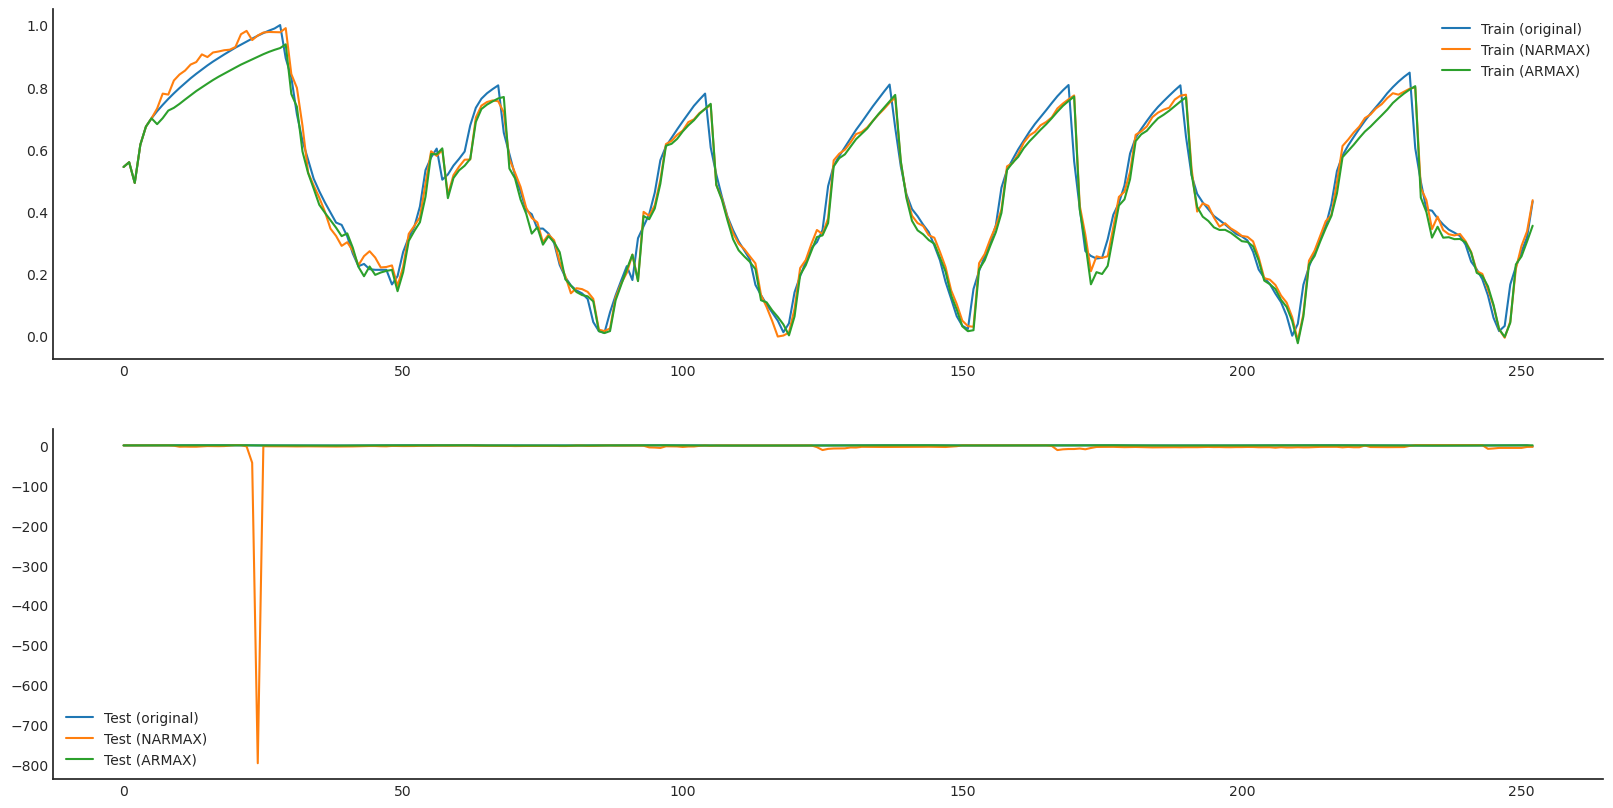

In [47]:
fig, ax = plt.subplots(2,1, figsize=(20,10))
ax[0].plot(y_tr, label='Train (original)')
ax[0].plot(y_tr_pr_OSA_NARMAX, label='Train (NARMAX)')
ax[0].plot(y_tr_pr_OSA_ARMAX, label='Train (ARMAX)')
ax[1].plot(y_te, label='Test (original)')
ax[1].plot(y_te_pr_OSA_NARMAX, label='Test (NARMAX)')
ax[1].plot(y_te_pr_OSA_ARMAX, label='Test (ARMAX)')
ax[0].legend()
ax[1].legend()

In [48]:
print('ARMAX Results:')
print('R2 score for OSA prediction (train) :', r2_score(y_tr, y_tr_pr_OSA_ARMAX))
print('R2 score for OSA prediction (test)  :', r2_score(y_te, y_te_pr_OSA_ARMAX))
print()
print('NARMAX Results:')
print('R2 score for OSA prediction (train) :', r2_score(y_tr, y_tr_pr_OSA_NARMAX))
print('R2 score for OSA prediction (test)  :', r2_score(y_te, y_te_pr_OSA_NARMAX))

ARMAX Results:
R2 score for OSA prediction (train) : 0.9636527482744156
R2 score for OSA prediction (test)  : 0.6303118842359351

NARMAX Results:
R2 score for OSA prediction (train) : 0.972972877522735
R2 score for OSA prediction (test)  : -28916.056514087213


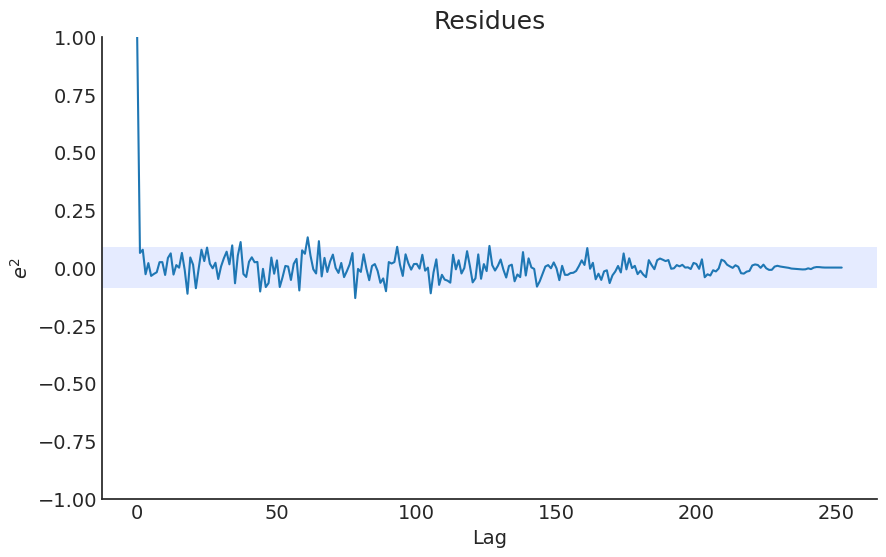

In [49]:
ee = compute_residues_autocorrelation(y_tr, y_tr_pr_OSA_NARMAX)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")

### 4.3 - Calculando predição FS

In [50]:
steps = None
y_tr_pr_FS_NARMAX = model_NARMAX.predict(X=X1_tr, y=y_tr,steps_ahead=steps)
y_te_pr_FS_NARMAX = model_NARMAX.predict(X=X1_te, y=y_te,steps_ahead=steps)
y_tr_pr_FS_ARMAX = model_ARMAX.predict(X=X1_tr, y=y_tr,steps_ahead=steps)
y_te_pr_FS_ARMAX = model_ARMAX.predict(X=X1_te, y=y_te,steps_ahead=steps)

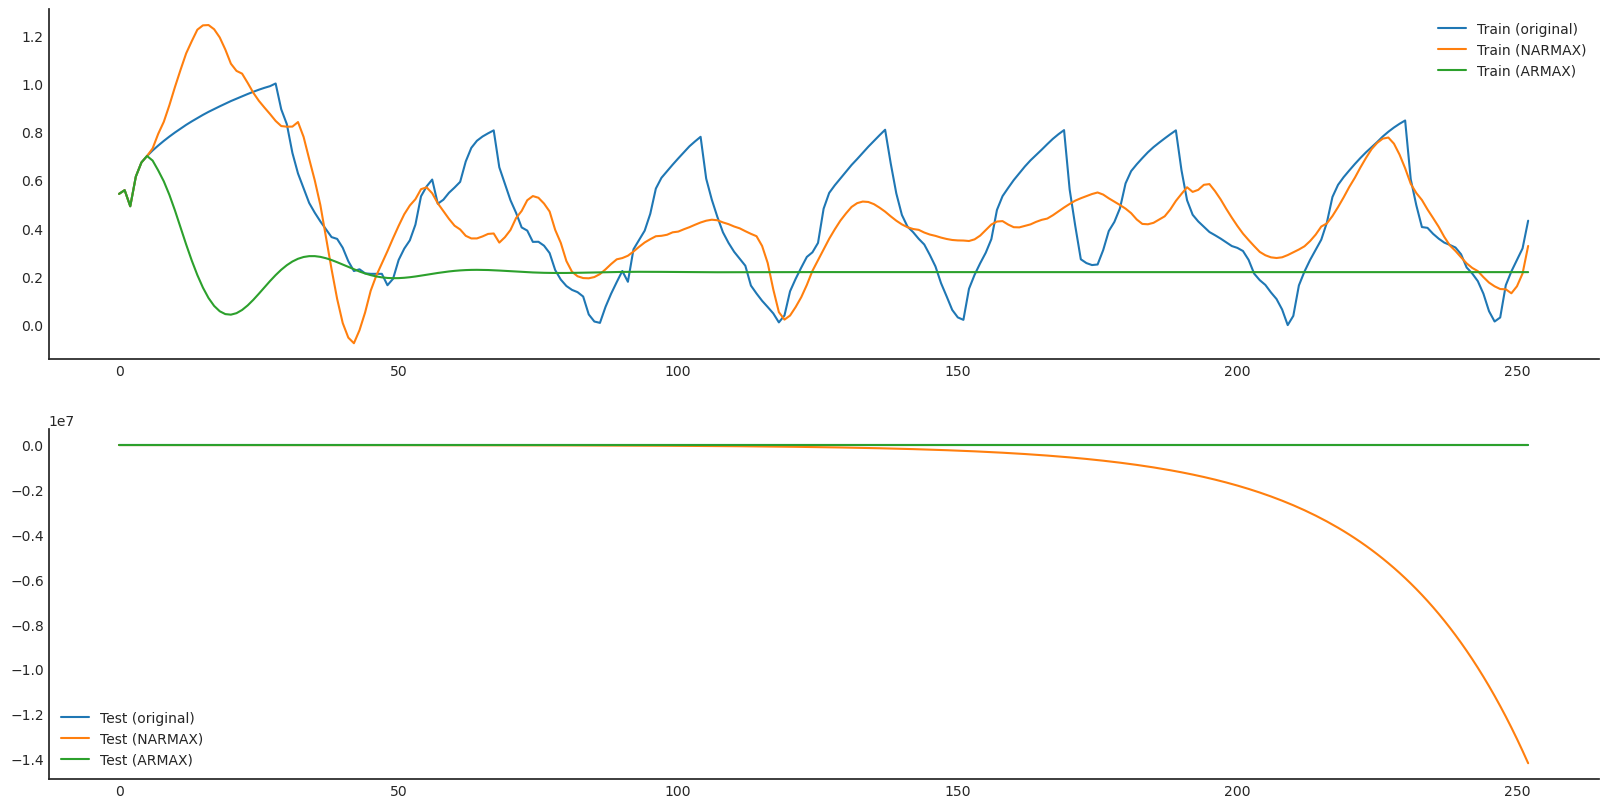

In [51]:
fig, ax = plt.subplots(2,1, figsize=(20,10))
ax[0].plot(y_tr, label='Train (original)')
ax[0].plot(y_tr_pr_FS_NARMAX, label='Train (NARMAX)')
ax[0].plot(y_tr_pr_FS_ARMAX, label='Train (ARMAX)')
ax[1].plot(y_te, label='Test (original)')
ax[1].plot(y_te_pr_FS_NARMAX, label='Test (NARMAX)')
ax[1].plot(y_te_pr_FS_ARMAX, label='Test (ARMAX)')
ax[0].legend()
ax[1].legend()

In [52]:
print('ARMAX Results:')
print('R2 score for FS prediction (train) :', r2_score(y_tr, y_tr_pr_FS_ARMAX))
print('R2 score for FS prediction (test)  :', r2_score(y_te, y_te_pr_FS_ARMAX))
print()
print('NARMAX Results:')
print('R2 score for FS prediction (train) :', r2_score(y_tr, y_tr_pr_FS_NARMAX))
print('R2 score for FS prediction (test)  :', r2_score(y_te, y_te_pr_FS_NARMAX))

ARMAX Results:
R2 score for FS prediction (train) : -0.9150141670031469
R2 score for FS prediction (test)  : -0.7534787171623027

NARMAX Results:
R2 score for FS prediction (train) : 0.4985005249625648
R2 score for FS prediction (test)  : -119479824965809.86


### 4.4 - Calculando predição com ajuste de teste de produção

In [53]:
steps = 60
y_tr_pr_FS_NARMAX = model_NARMAX.predict(X=X1_tr, y=y_tr,steps_ahead=steps)
y_te_pr_FS_NARMAX = model_NARMAX.predict(X=X1_te, y=y_te,steps_ahead=steps)
y_tr_pr_FS_ARMAX = model_ARMAX.predict(X=X1_tr, y=y_tr,steps_ahead=steps)
y_te_pr_FS_ARMAX = model_ARMAX.predict(X=X1_te, y=y_te,steps_ahead=steps)

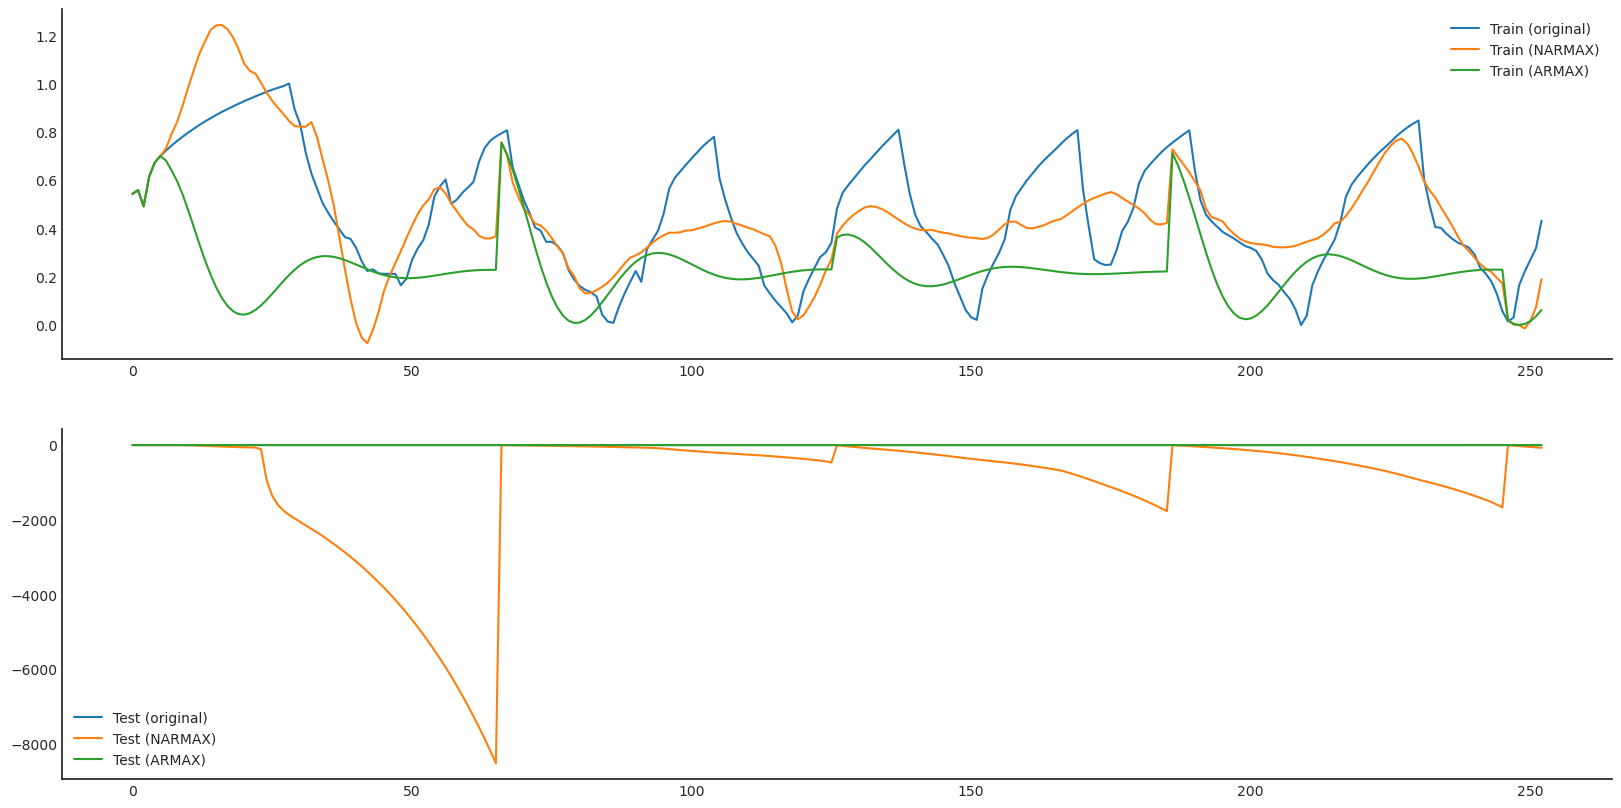

In [54]:
fig, ax = plt.subplots(2,1, figsize=(20,10))
ax[0].plot(y_tr, label='Train (original)')
ax[0].plot(y_tr_pr_FS_NARMAX, label='Train (NARMAX)')
ax[0].plot(y_tr_pr_FS_ARMAX, label='Train (ARMAX)')
ax[1].plot(y_te, label='Test (original)')
ax[1].plot(y_te_pr_FS_NARMAX, label='Test (NARMAX)')
ax[1].plot(y_te_pr_FS_ARMAX, label='Test (ARMAX)')
ax[0].legend()
ax[1].legend()

In [55]:
print('ARMAX Results:')
print('R2 score for n-steps prediction (train) :', r2_score(y_tr, y_tr_pr_FS_ARMAX))
print('R2 score for n-steps prediction (test)  :', r2_score(y_te, y_te_pr_FS_ARMAX))
print()
print('NARMAX Results:')
print('R2 score for n-steps prediction (train) :', r2_score(y_tr, y_tr_pr_FS_NARMAX))
print('R2 score for n-steps prediction (test)  :', r2_score(y_te, y_te_pr_FS_NARMAX))

ARMAX Results:
R2 score for n-steps prediction (train) : -0.7742703331816512
R2 score for n-steps prediction (test)  : -0.7056446145003099

NARMAX Results:
R2 score for n-steps prediction (train) : 0.5485019363273781
R2 score for n-steps prediction (test)  : -44133897.53908515


## Passo 5 - Conclusões

FS tá ruim, mas OSA mostra que tem jogo